Author: Adam Moss

Data from 

https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-hospital-activity/ 

https://www.england.nhs.uk/statistics/statistical-work-areas/uec-sitrep/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import urllib3
from dateutil import parser
import matplotlib.dates as mdates
import os
import sys

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,path)

In [4]:
from covid.utils import get_covid_activity, get_uec_sitrep

In [5]:
colors = ['#006FED', '#E03424', 'gray', '#009966', '#000866', '#336600', '#006633', 'm', 'r']

In [6]:
covid_activity = get_covid_activity()

In [7]:
covid_activity

,date,areaName,hospitalCases,covidOccupiedMVBeds
0,2020-08-01,ENGLAND,879,74
1,2020-08-02,ENGLAND,847,72
2,2020-08-03,ENGLAND,842,67
3,2020-08-04,ENGLAND,807,65
4,2020-08-05,ENGLAND,805,63
...,...,...,...,...
1267,2021-01-02,South West,1236,79
1268,2021-01-03,South West,1323,83
1269,2021-01-04,South West,1401,97
1270,2021-01-05,South West,1414,98


In [8]:
sitreps = []
for i, year in enumerate(['202021', '201920', '201819', '201718', '201617']):
    sitrep = get_uec_sitrep(year)
    sitrep['year'] = year
    sitrep['rescaled_date'] = sitrep['date']  + datetime.timedelta(days=i*365)
    sitreps.append(sitrep)
sitrep = pd.concat(sitreps)

In [9]:
sitrep

,areaName,code,trust,date,availableMVBeds,occupiedMVBeds,year,rescaled_date
0,East of England,RC9,Bedfordshire Hospitals NHS Foundation Trust,2020-11-02,28.0,19.0,202021,2020-11-02
1,East of England,RGT,Cambridge University Hospitals NHS Foundation ...,2020-11-02,69.0,58.0,202021,2020-11-02
2,East of England,RWH,East and North Hertfordshire NHS Trust,2020-11-02,18.0,9.0,202021,2020-11-02
3,East of England,RDE,East Suffolk and North Essex NHS Foundation Trust,2020-11-02,25.0,20.0,202021,2020-11-02
4,East of England,RGP,James Paget University Hospitals NHS Foundatio...,2020-11-02,12.0,9.0,202021,2020-11-02
...,...,...,...,...,...,...,...,...
15499,South Of England Commissioning Region,RHM,University Hospital Southampton NHS Foundation...,2017-03-12,57.0,49.0,201617,2021-03-11
15500,South Of England Commissioning Region,RA7,University Hospitals Bristol NHS Foundation Trust,2017-03-12,55.0,51.0,201617,2021-03-11
15501,South Of England Commissioning Region,RYR,Western Sussex Hospitals NHS Foundation Trust,2017-03-12,22.0,16.0,201617,2021-03-11
15502,South Of England Commissioning Region,RA3,Weston Area Health NHS Trust,2017-03-12,0.0,0.0,201617,2021-03-11


In [10]:
# Correct data
sitrep.loc[(sitrep['date'] == datetime.datetime(2017,12,10)) & (sitrep['trust'] == 'Barts Health NHS Trust'), 'occupiedMVBeds'] = 110

In [17]:
def make_plot(region, plot_covid_only=False, plot_capacity=False):
    plt.figure(figsize=(18,10))    
    if plot_covid_only:
        covid_activity_region = covid_activity[covid_activity['areaName'] == region]
        plt.plot(covid_activity_region['date'], covid_activity_region['covidOccupiedMVBeds'], label='2020/21 (Covid Only)', color=colors[0], linestyle='--')
        plt.title(region + ' ICU occupancy')
    for i, year in enumerate(sitrep['year'].unique()):
        sitrep_region = sitrep[(sitrep['year'] == year) & (sitrep['areaName'].str.contains(region))]
        sitrep_region = sitrep_region.groupby(['date', 'rescaled_date']).sum().reset_index()
        plt.plot(sitrep_region['rescaled_date'], sitrep_region['occupiedMVBeds'], label=year, color=colors[i])
        if plot_capacity:
            plt.plot(sitrep_region['rescaled_date'], sitrep_region['availableMVBeds'], label=year + ' (available)', color=colors[i], linestyle='--')
    plt.xlabel('Date (rescaled to this year)', fontsize=14)
    plt.ylabel('Number', fontsize=14)
    plt.legend(loc='upper left')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.set_xlim([datetime.datetime(2020, 11, 11), datetime.datetime.now()])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.gcf().autofmt_xdate() # Rotation
    plt.grid()
    plt.suptitle(region + ' ICU occupancy (type 1 accute trusts)', fontsize=14)
    plt.title('https://www.england.nhs.uk/statistics/statistical-work-areas/uec-sitrep/', fontsize=12)
    plt.tight_layout()
    plt.savefig('plots/icu_occupancy/' + region.replace(' ', '') + '.png', transparent=False, facecolor='white')

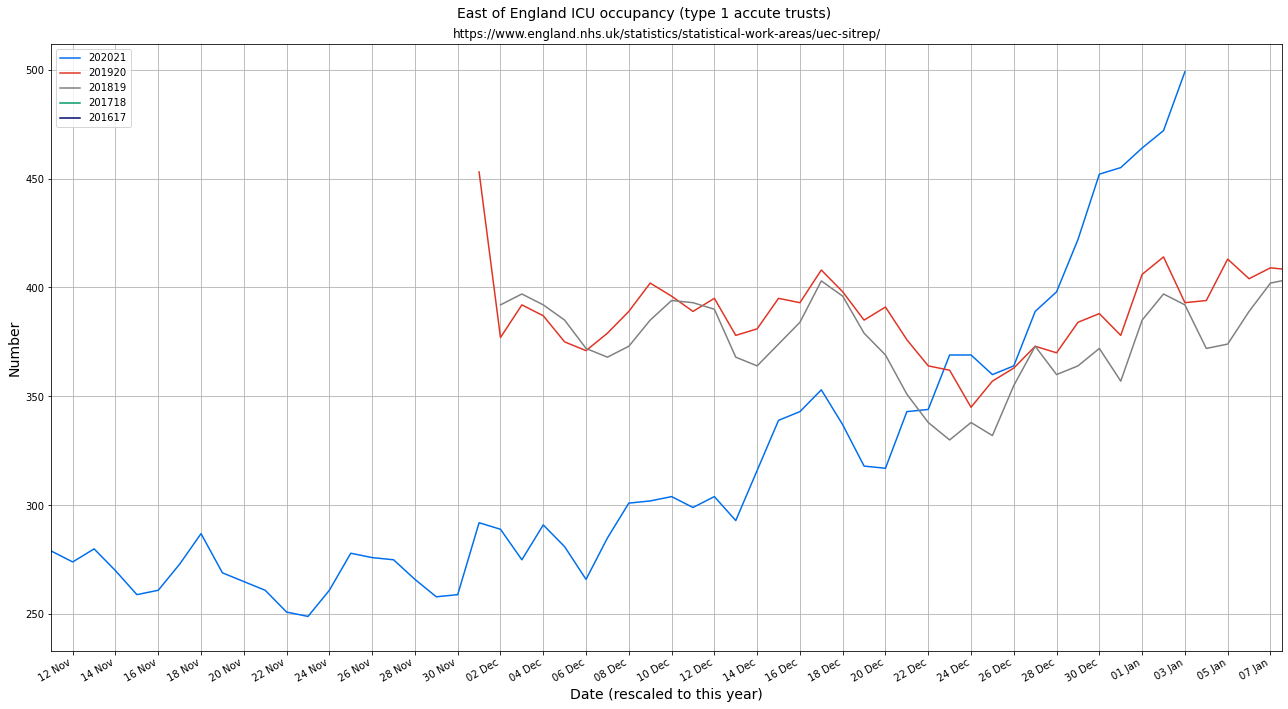

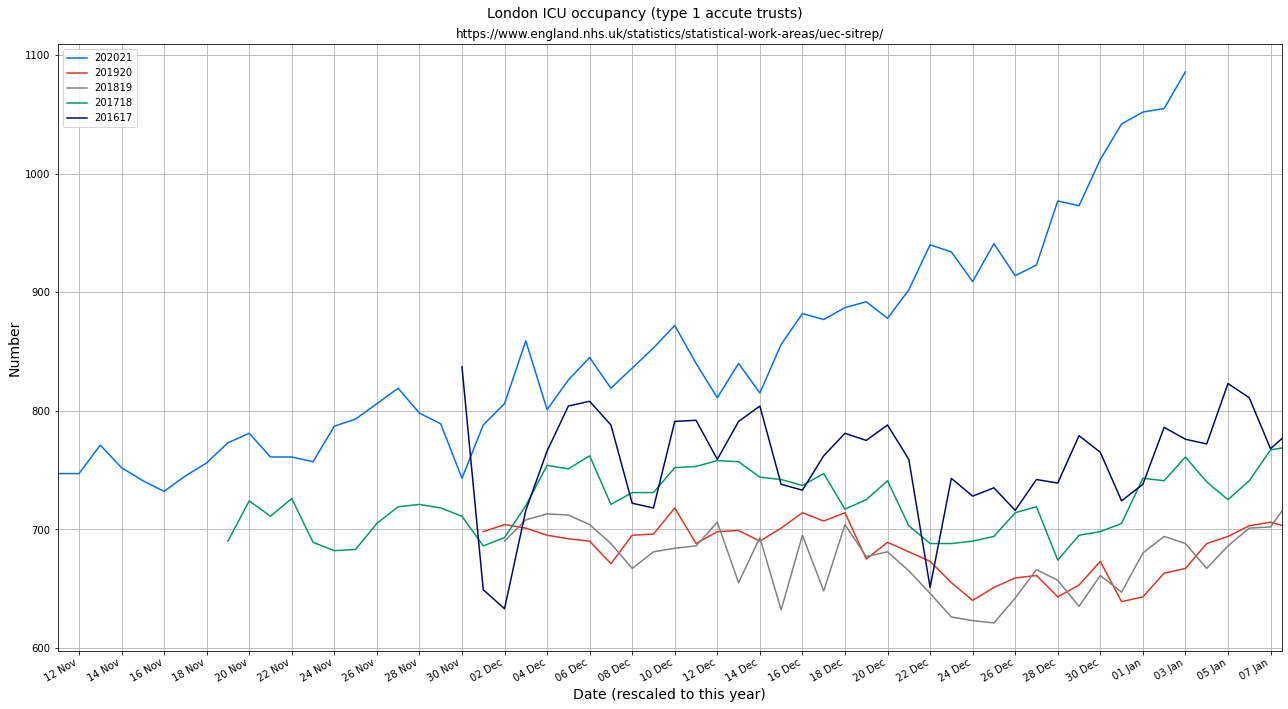

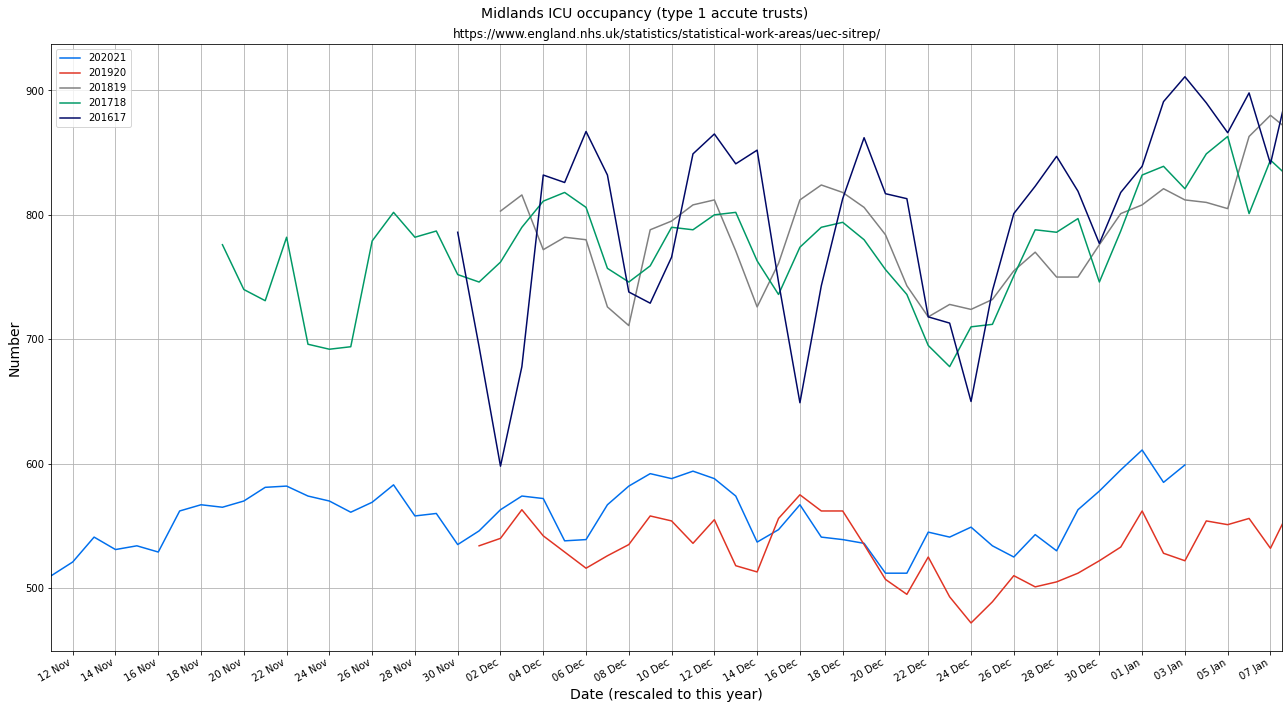

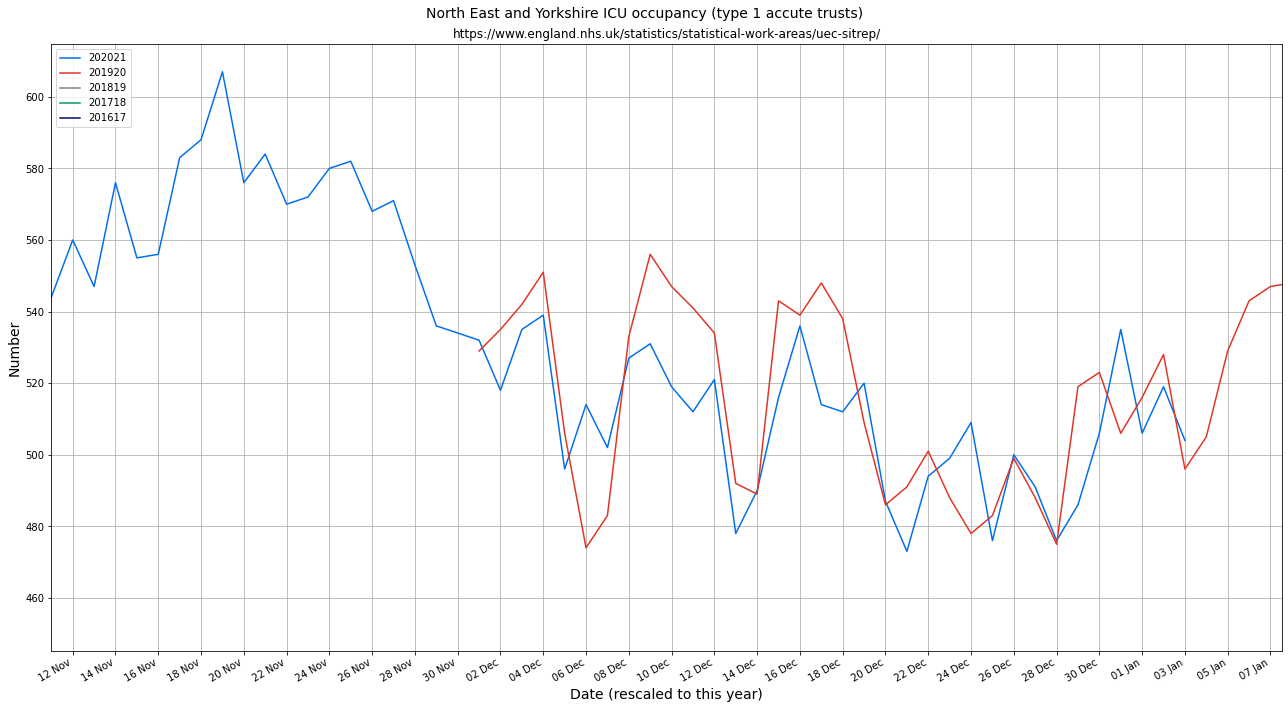

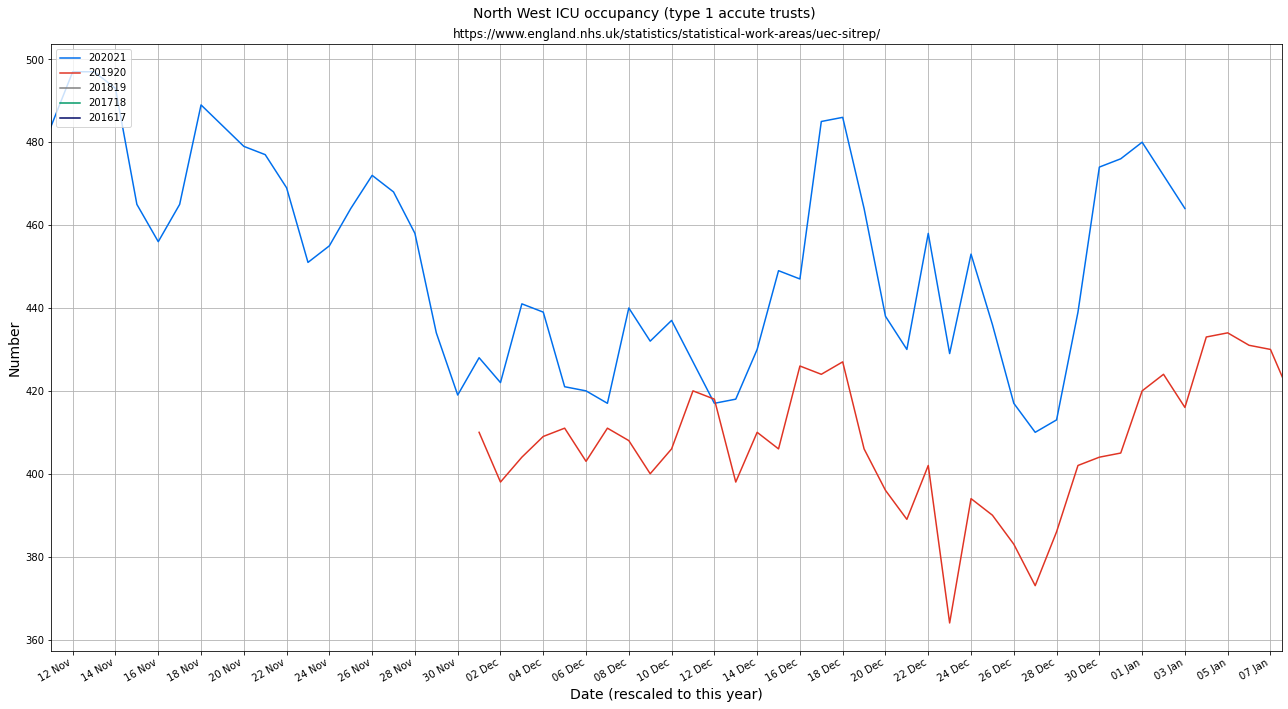

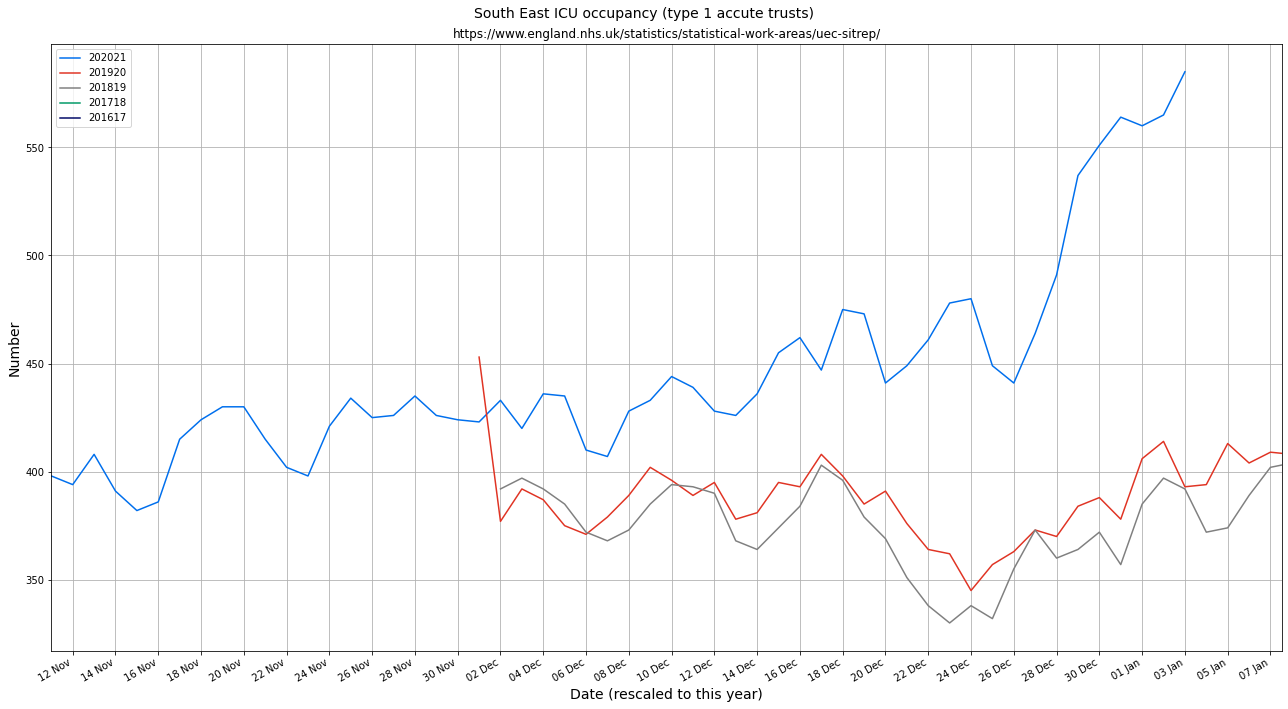

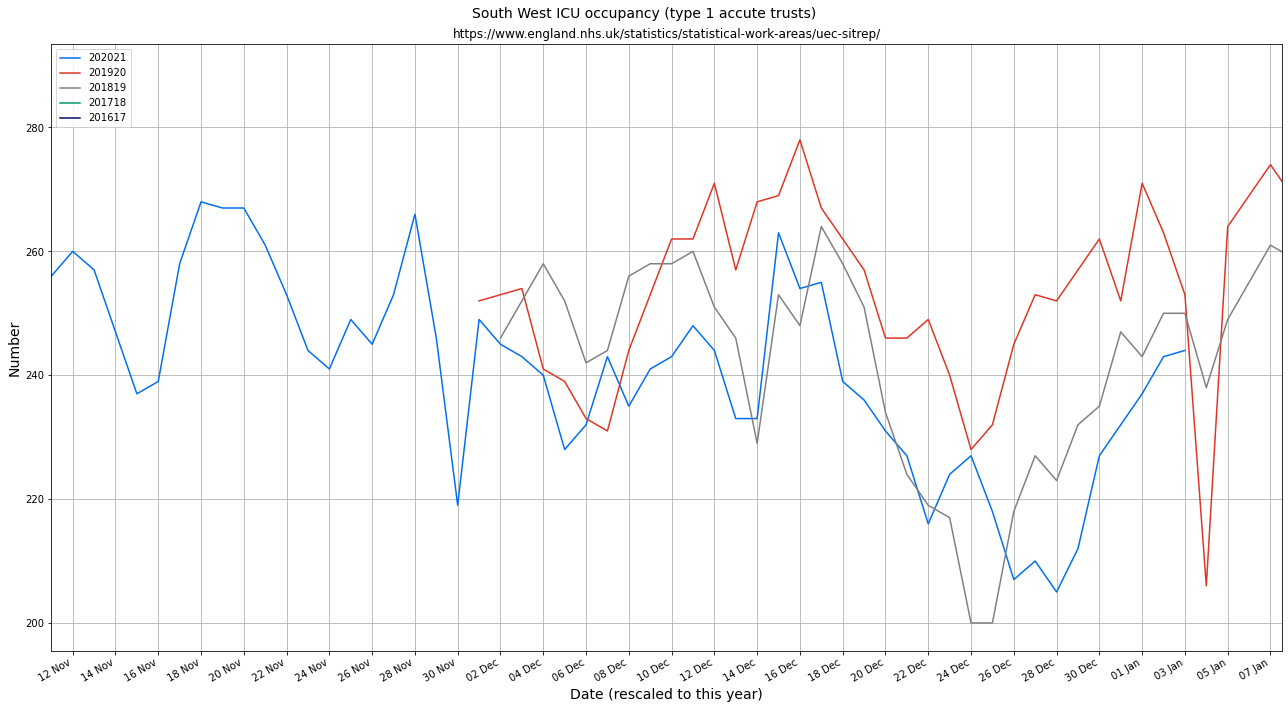

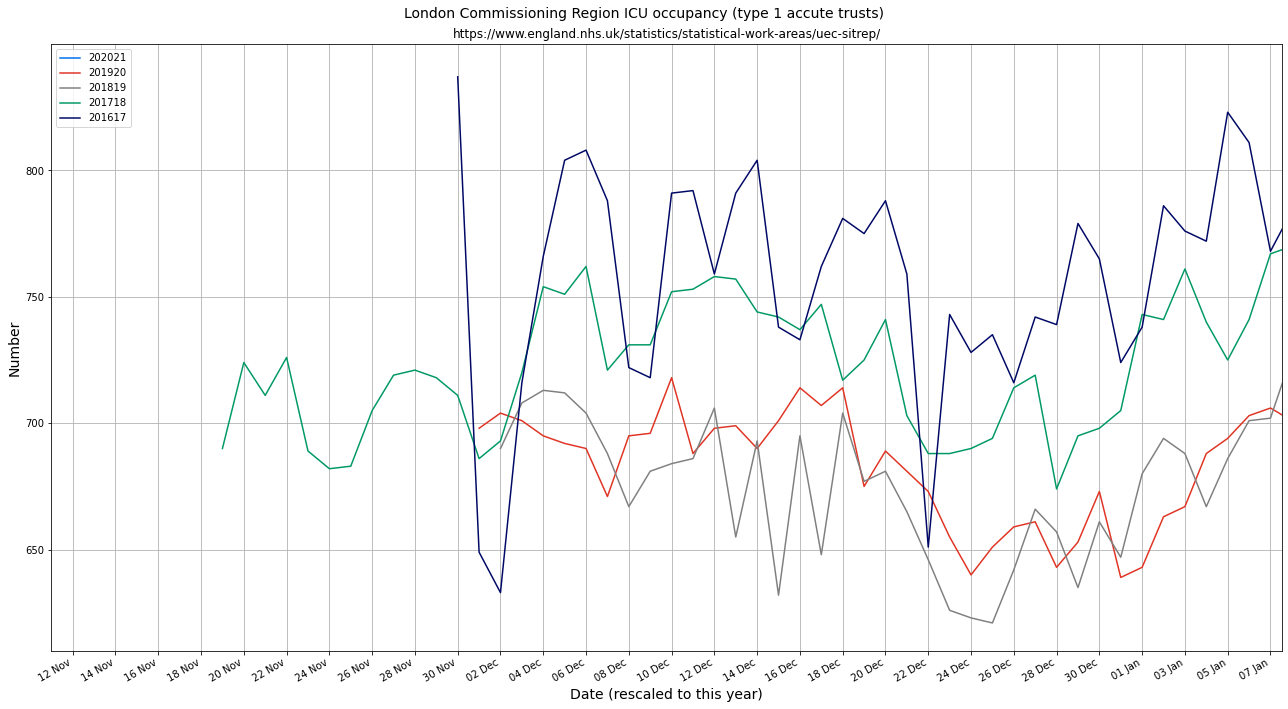

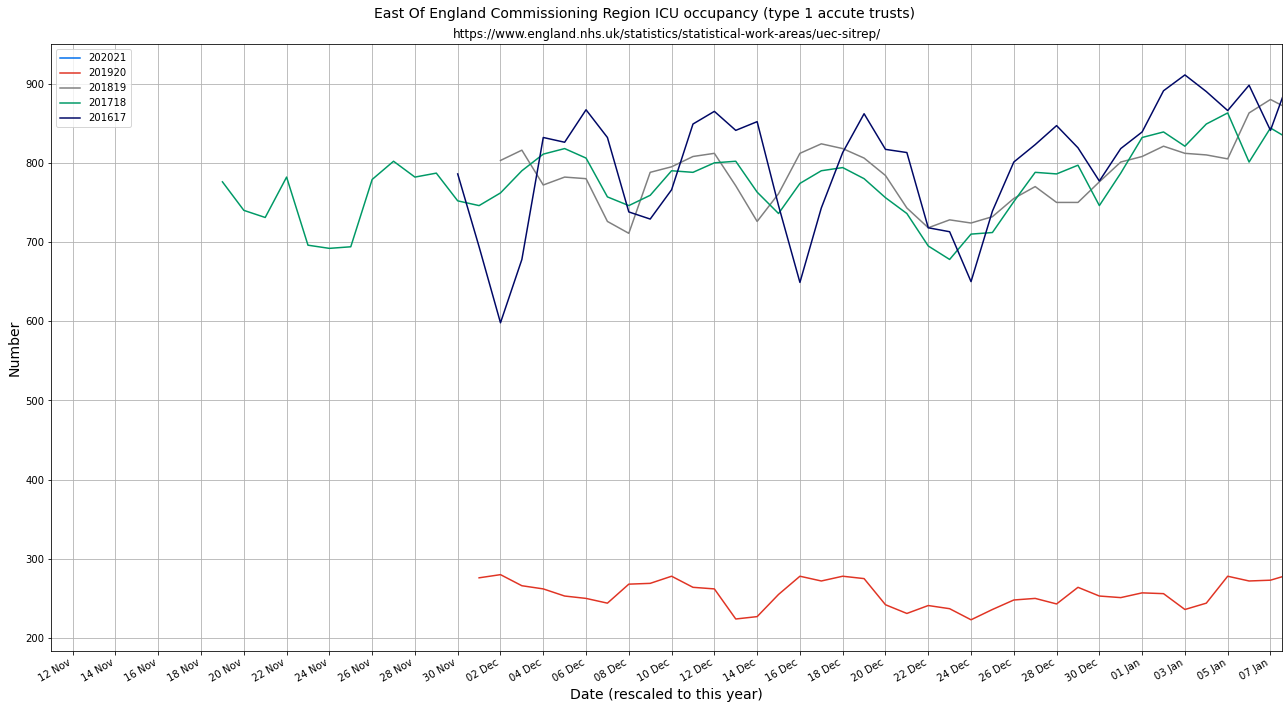

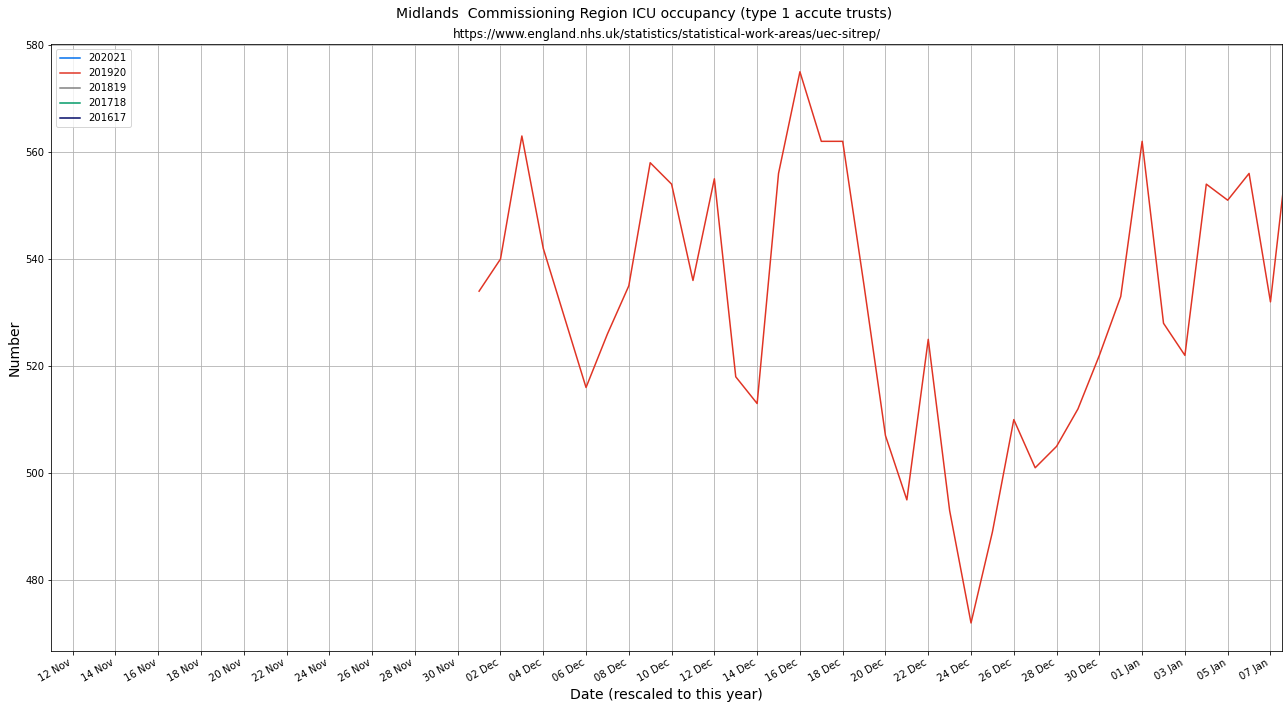

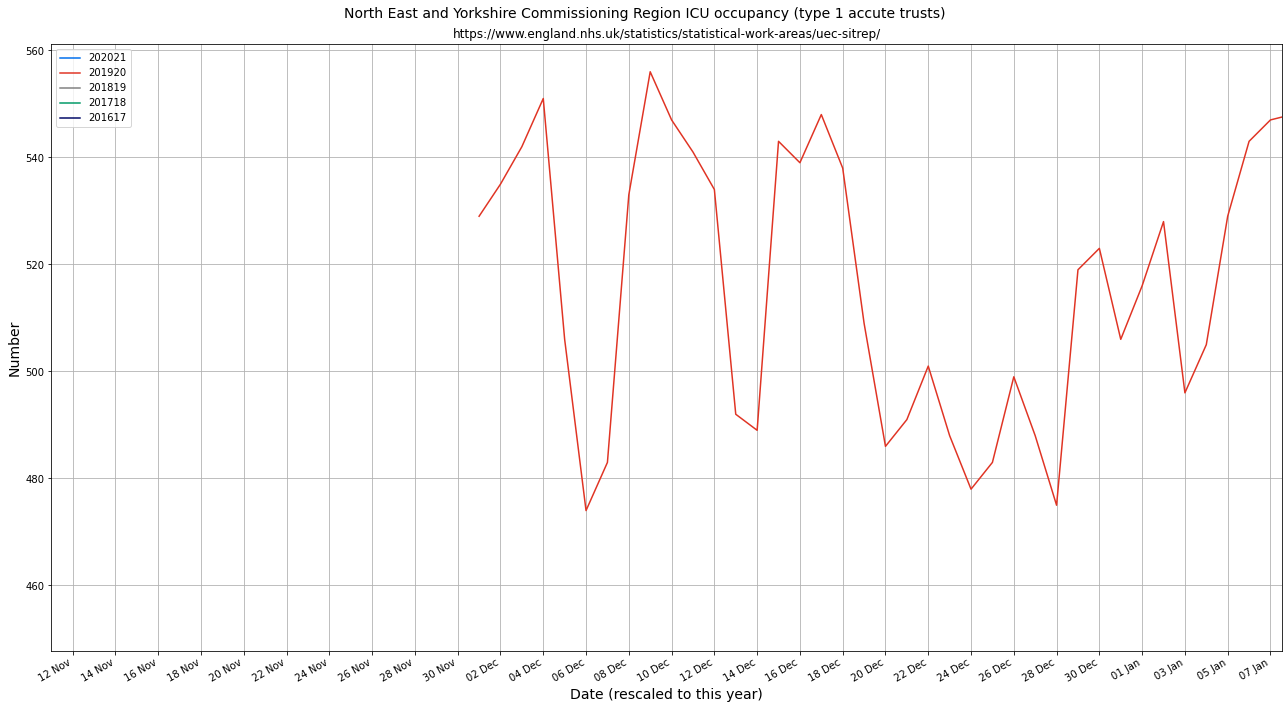

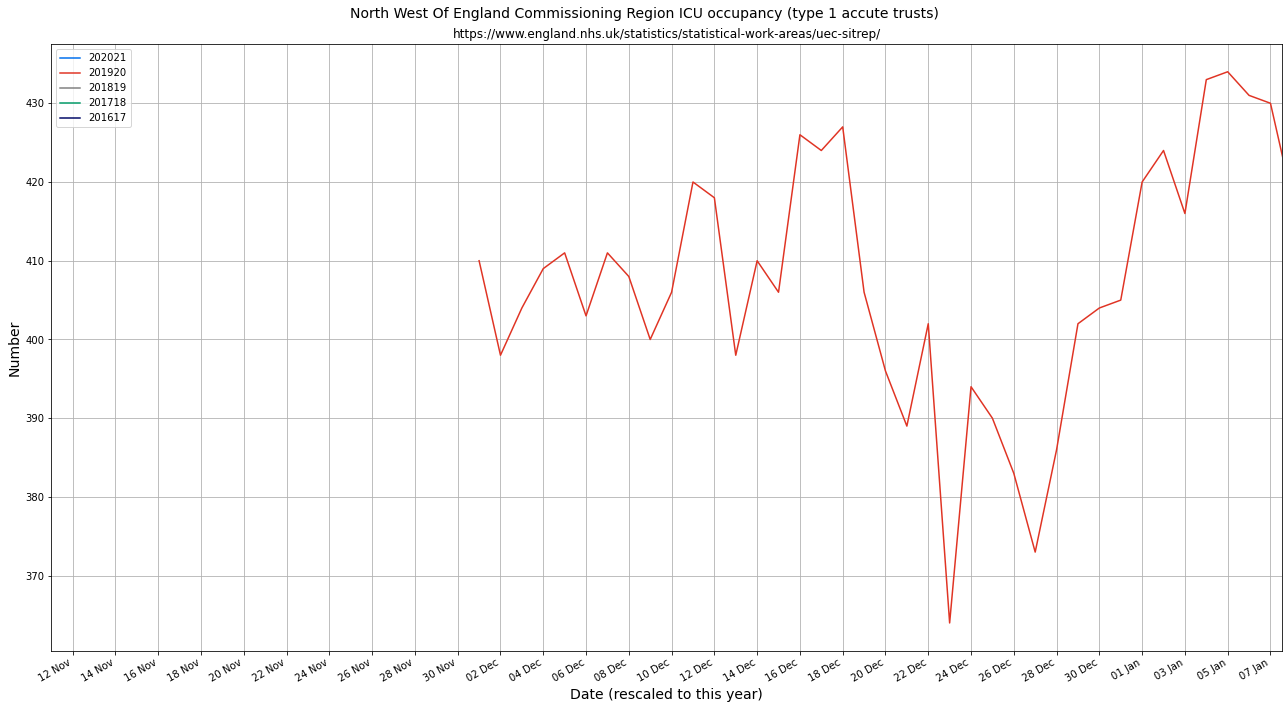

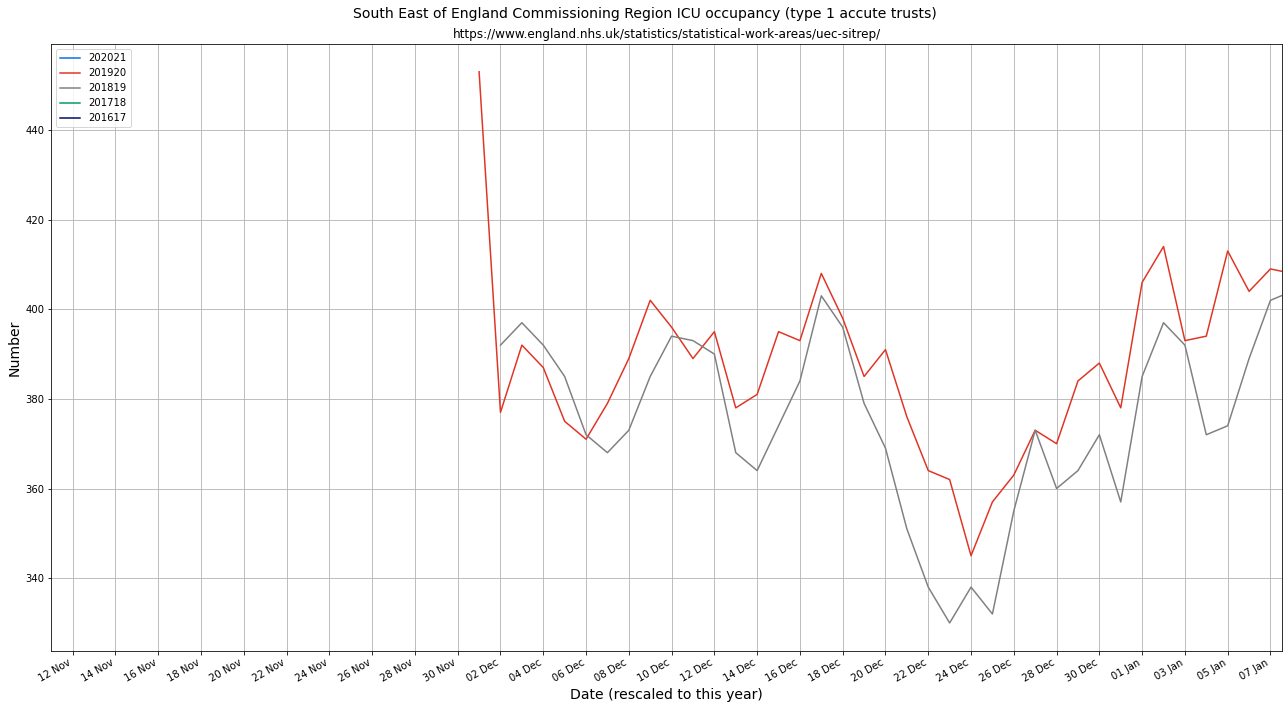

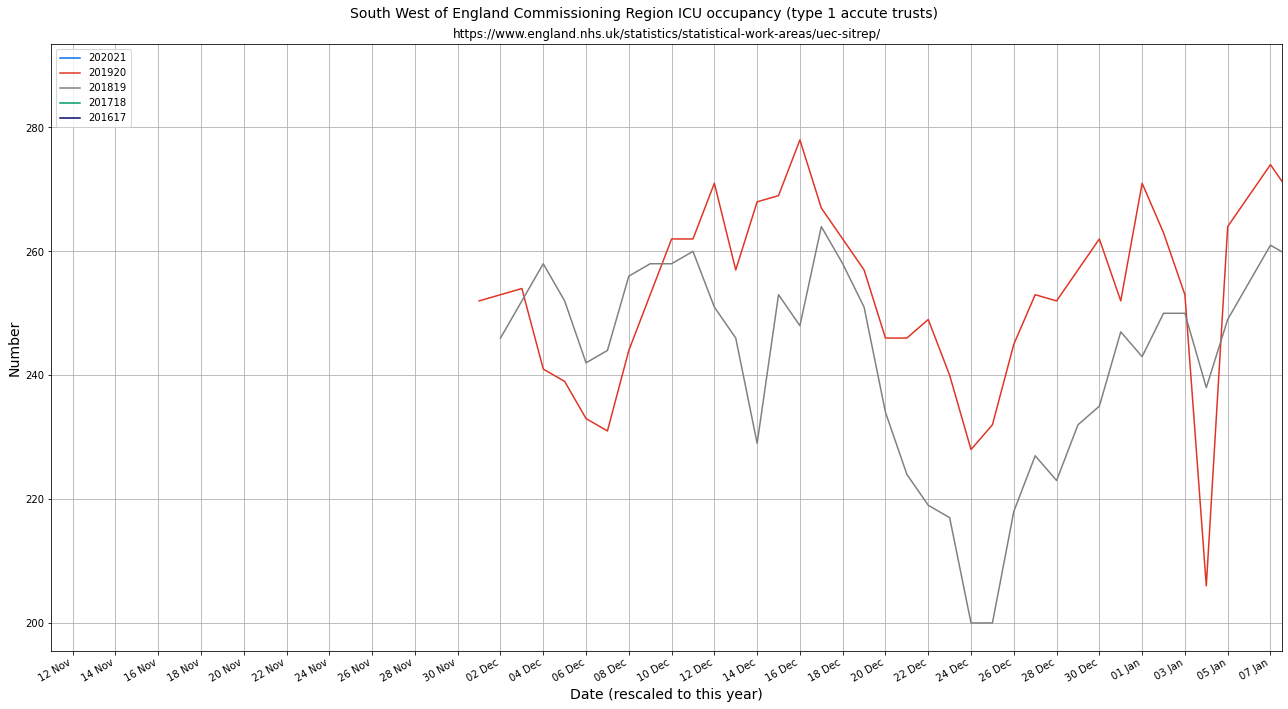

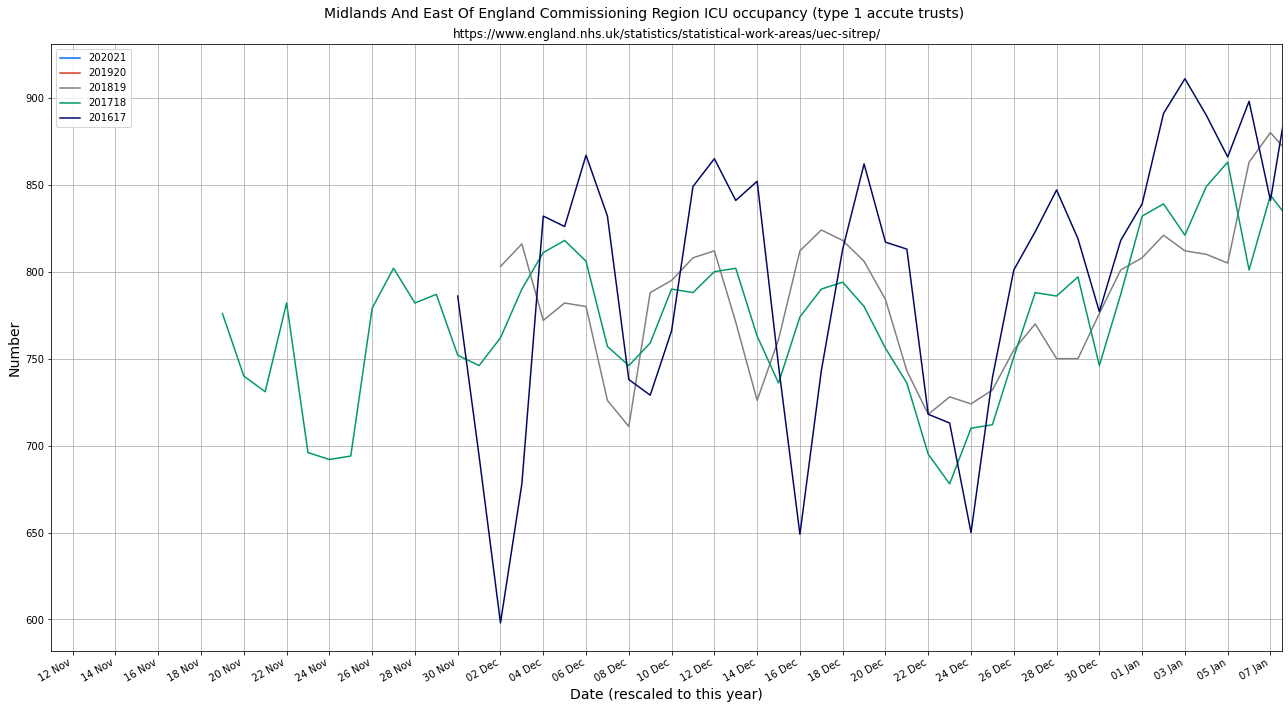

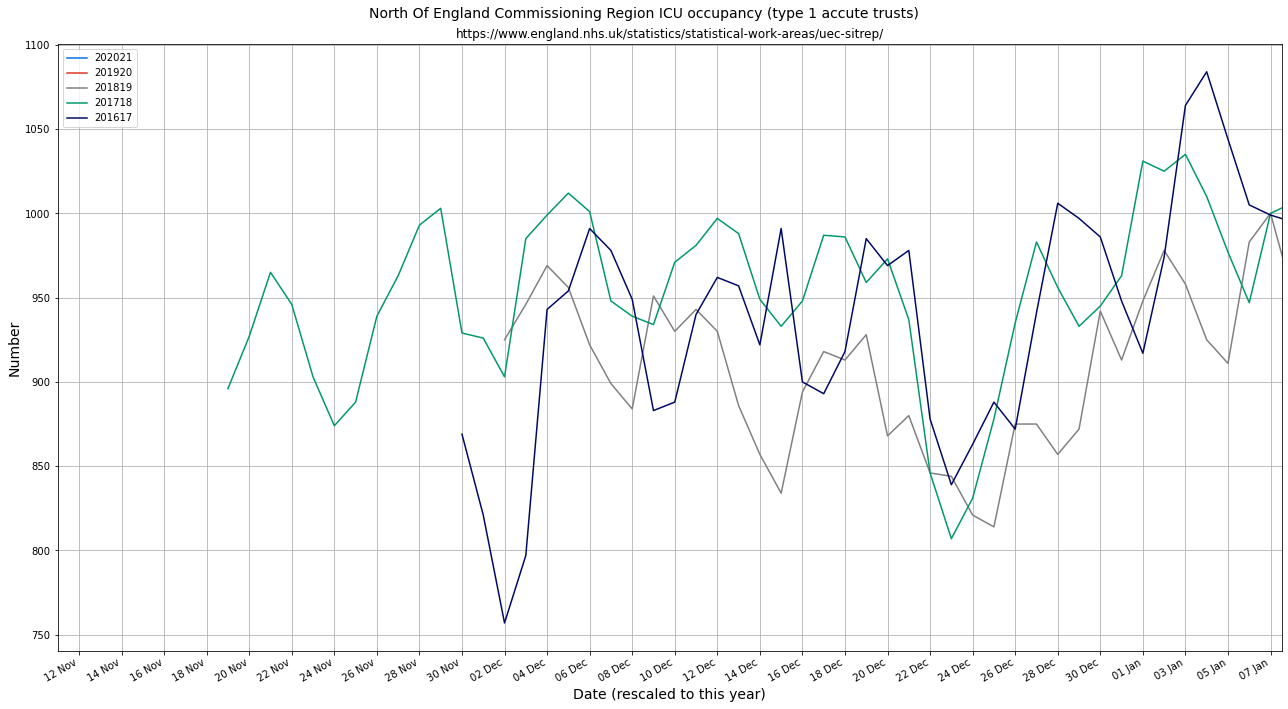

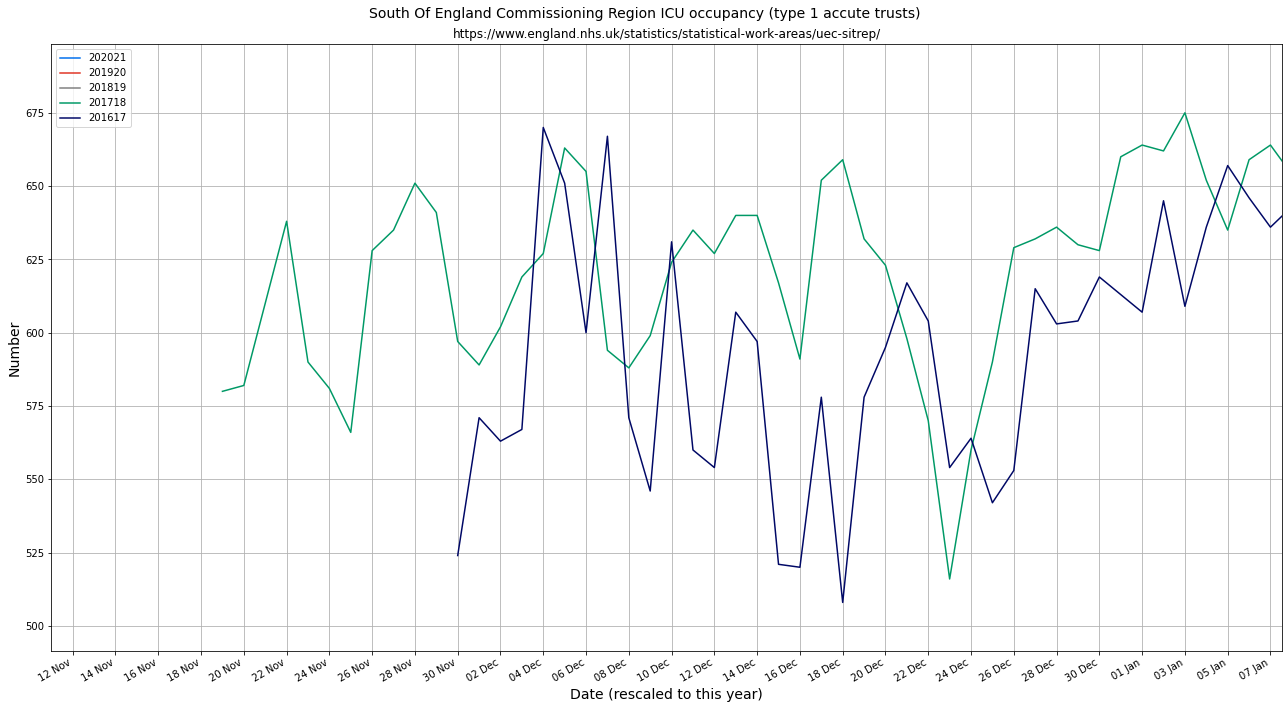

In [18]:
for region in sitrep['areaName'].unique():
    make_plot(region, plot_covid_only=False)